# Season A Priori Flag Summary

**Steven Murray**, Last Revised April 2023

This notebook shows very simple summaries of the season in terms of observed antennas, times and frequencies, with flags. These are derived from the "scouting" flagger, `full_day_auto_checker.ipynb` in `hera_notebook_templates`. 

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)
import matplotlib.pyplot as plt
import matplotlib
import glob
import re
import os
from pathlib import Path
from astropy.time import Time
from IPython.display import display, HTML
from hera_notebook_templates.utils import status_colors, Antenna
import yaml
from astropy import units as u
from astropy.coordinates import EarthLocation
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
display(HTML("<style>.container { width:100% !important; }</style>"))

In [52]:
# Where to find the a priori YAML files
yaml_folder = Path('/lustre/aoc/projects/hera/h6c-analysis/day_flags/0/')

In [4]:
# load yamls in chronological order
yamls = sorted(yaml_folder.glob('*_flags.yaml'))
print(f'Found {len(yamls)} a-priori YAMLS in {yaml_folder}')

Found 172 a-priori YAMLS in /lustre/aoc/projects/hera/h6c-analysis/day_flags/0


## Load Data

In [19]:
data = {}
for y in yamls:
    int_jd = int(y.name[y.name.index("245"):y.name.index("245")+7])
    with open(y, 'r') as fl:
        data[int_jd] = yaml.load(fl, Loader=yaml.SafeLoader)
        
        # For now, mock that we have the full ants, time range and freq range
        # data[int_jd]['all_ants'] = [(i, 'Jee') for i in range(350)] + [(i, 'Jnn') for i in range(350)]
        # data[int_jd]['jd_range'] = [int_jd + 0.3, int_jd + 0.7]
        # data[int_jd]['freq_range'] = [45e6, 250e6]

## Time-Based Flags

In [20]:
# Calculate the total amount of time that is flagged
hours_flagged = 0
hours_observed = 0
for jd, d in data.items():
    hours_observed += (d['jd_range'][1] - d['jd_range'][0])*24
    for flg in d['JD_flags']:
        hours_flagged += (flg[1] - flg[0])*24

In [21]:
hours_flagged_frac = hours_flagged / (hours_observed)

In [22]:
print(f"Total number of hours flagged: {hours_flagged:.2f}")
print(f"Percentage of hours flagged: { hours_flagged_frac * 100:.2f}%")

Total number of hours flagged: 360.02
Percentage of hours flagged: 25.29%


In [53]:
lsts = np.arange(0, 24, 9.6/60/60)

In [54]:
location = EarthLocation(lat=-30.717*u.deg, lon=21.417*u.deg)

In [55]:
lst_flags = {}
for jd, d in data.items():
    jdmin, jdmax = d['jd_range']
    tmin = Time(jdmin, format='jd', scale='utc', location=location)
    tmax = Time(jdmax, format='jd', scale='utc', location=location)
    
    lstmin = tmin.sidereal_time("apparent").hour
    lstmax = tmax.sidereal_time("apparent").hour
    
    if lstmax < lstmin:
        lstmax += 24

    thislst = np.where(lsts<lstmin, lsts + 24, lsts)
    flags = thislst > lstmax
    if np.all(flags):
        print(jd, lstmin, lstmax)
    for flgrange in d['JD_flags']:
        tmin = Time(flgrange[0], format='jd', scale='utc', location=location)
        tmax = Time(flgrange[1], format='jd', scale='utc', location=location)
        lstmin = tmin.sidereal_time("apparent").hour
        lstmax = tmax.sidereal_time("apparent").hour
        if lstmax < lstmin:
            lstmax += 24
            
        flags[(thislst>=lstmin) & (thislst < lstmax)] = True
    lst_flags[jd] = flags
    
    

In [56]:
all_days = np.array(list(range(min(data.keys()), max(data.keys()) + 1)))

In [57]:
lst_flag_array = np.zeros((len(all_days), len(lsts)), dtype=bool)

for i, day in enumerate(all_days):
    lst_flag_array[i] = lst_flags.get(day, True)

Text(0.5, 1.0, 'JDs and LSTs flagged over the Season (purple)')

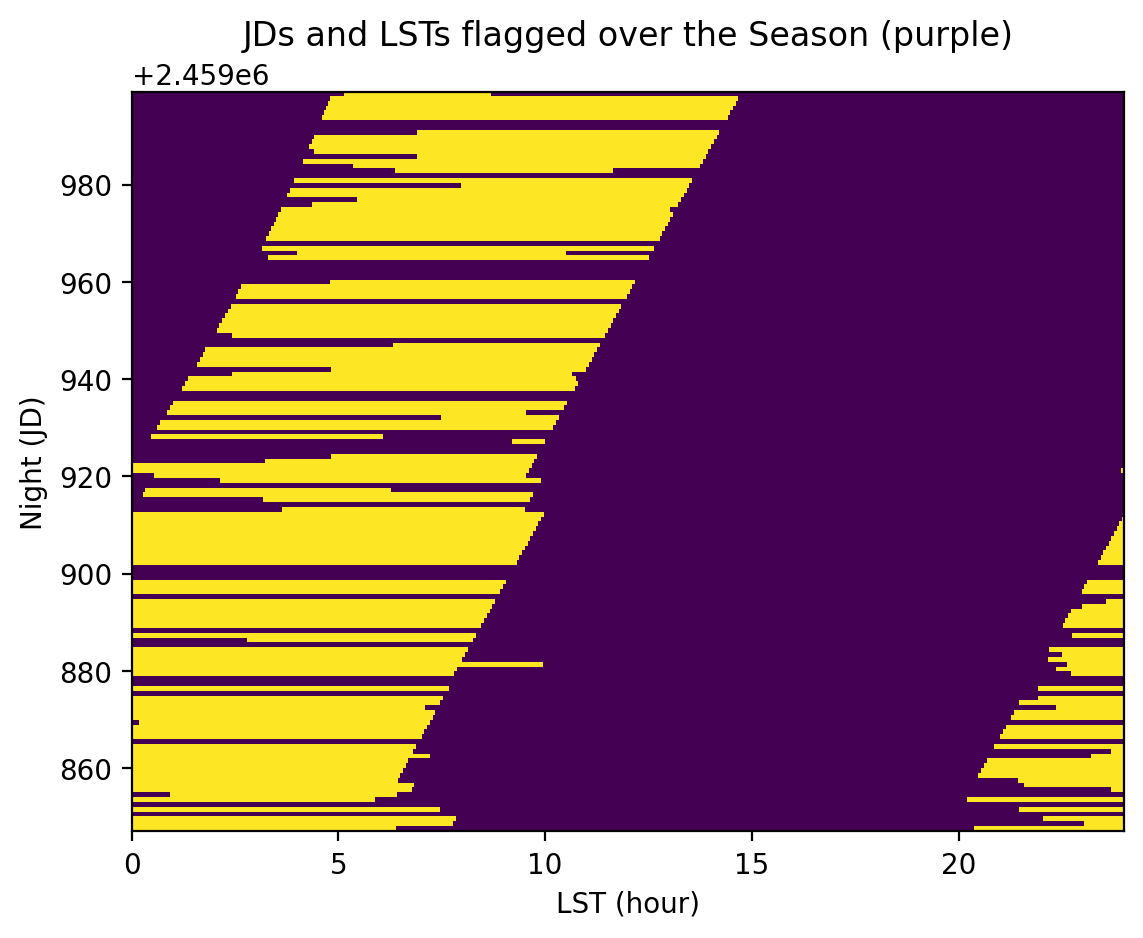

In [58]:
plt.imshow(~lst_flag_array, aspect='auto', interpolation='none', extent=(lsts.min(), lsts.max(), min(all_days), max(all_days)), origin='lower')
plt.xlabel("LST (hour)")
plt.ylabel("Night (JD)")
plt.title("JDs and LSTs flagged over the Season (purple)")

## Antenna-Based Flags

In [34]:
ngood_ants = {'Jnn': {}, 'Jee': {}}
ntot_ants = {'Jnn': {}, 'Jee': {}}

for pol in ['Jnn', "Jee"]:
    for jd, d in data.items():
        ntot_ants[pol][jd] = len([a for a in d['all_ant'] if a[1] ==pol])
        ngood_ants[pol][jd] = ntot_ants[pol][jd] - len([a for a in d['ex_ants'] if a[1] == pol])

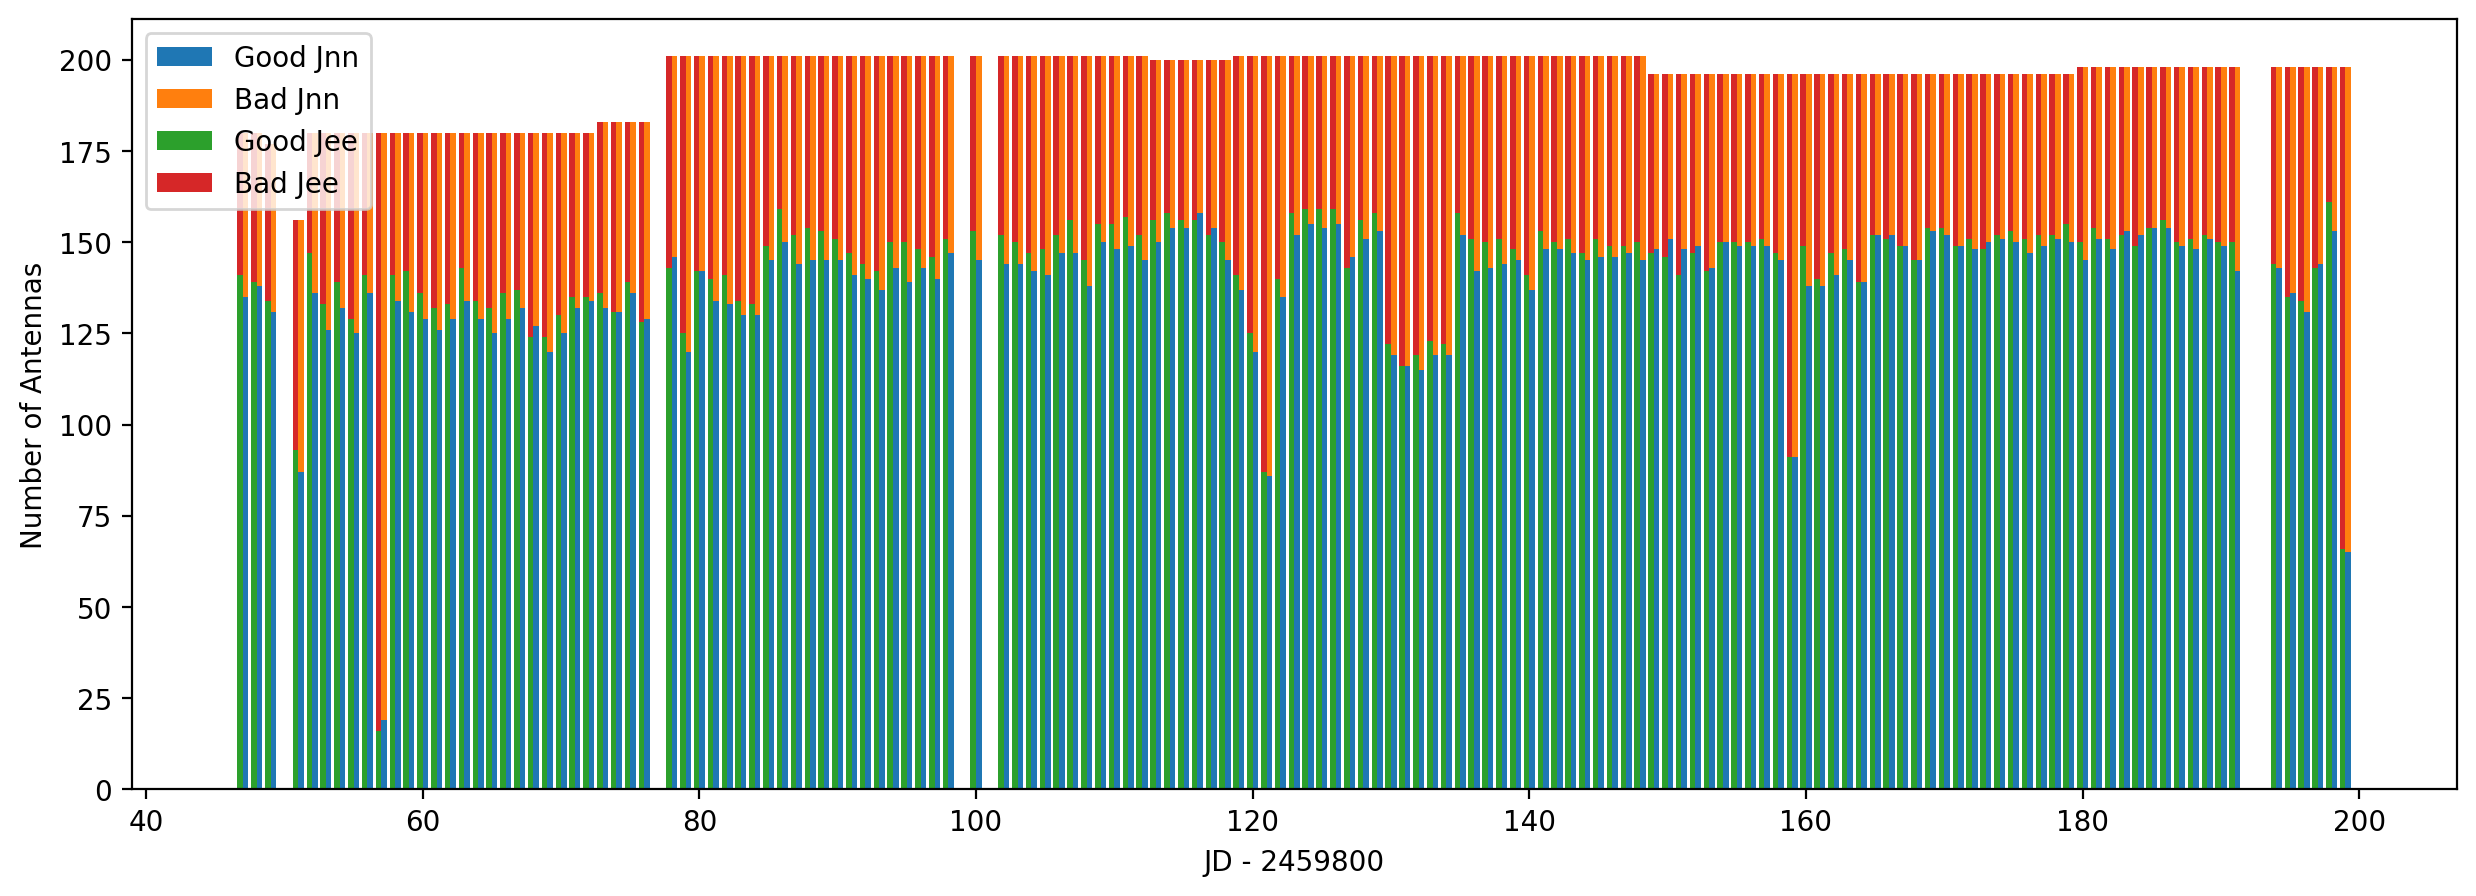

In [39]:
plt.figure(figsize=(15, 5))
for i, pol in enumerate(ngood_ants):
    if i==1:
        width=-0.4
    else:
        width=0.4
    plt.bar(all_days-2459800, [ngood_ants[pol].get(d, 0) for d in all_days], align='edge', width=width, label=f'Good {pol}')
    plt.bar(all_days-2459800, [ntot_ants[pol].get(d, 0) -  ngood_ants[pol].get(d, 0) for d in all_days], bottom=[ngood_ants[pol].get(d, 0) for d in all_days], align='edge', width=width, label=f'Bad {pol}')
plt.xlabel("JD - 2459800")
plt.ylabel("Number of Antennas")
plt.legend()

## Antenna-Time Flags

In [40]:
ngood_ant_hours = {'Jnn': {}, 'Jee': {}}
ntot_ant_hours = {'Jnn': {}, 'Jee': {}}

for pol in ['Jnn', "Jee"]:
    for jd, d in data.items():
        ntot_ant_hours[pol][jd] = ntot_ants[pol][jd] * (d['jd_range'][1] - d['jd_range'][0])*24
        ngood_ant_hours[pol][jd] = ngood_ants[pol][jd] * ((d['jd_range'][1] - d['jd_range'][0])*24 - sum((x[1]- x[0])*24 for x in d['JD_flags']))

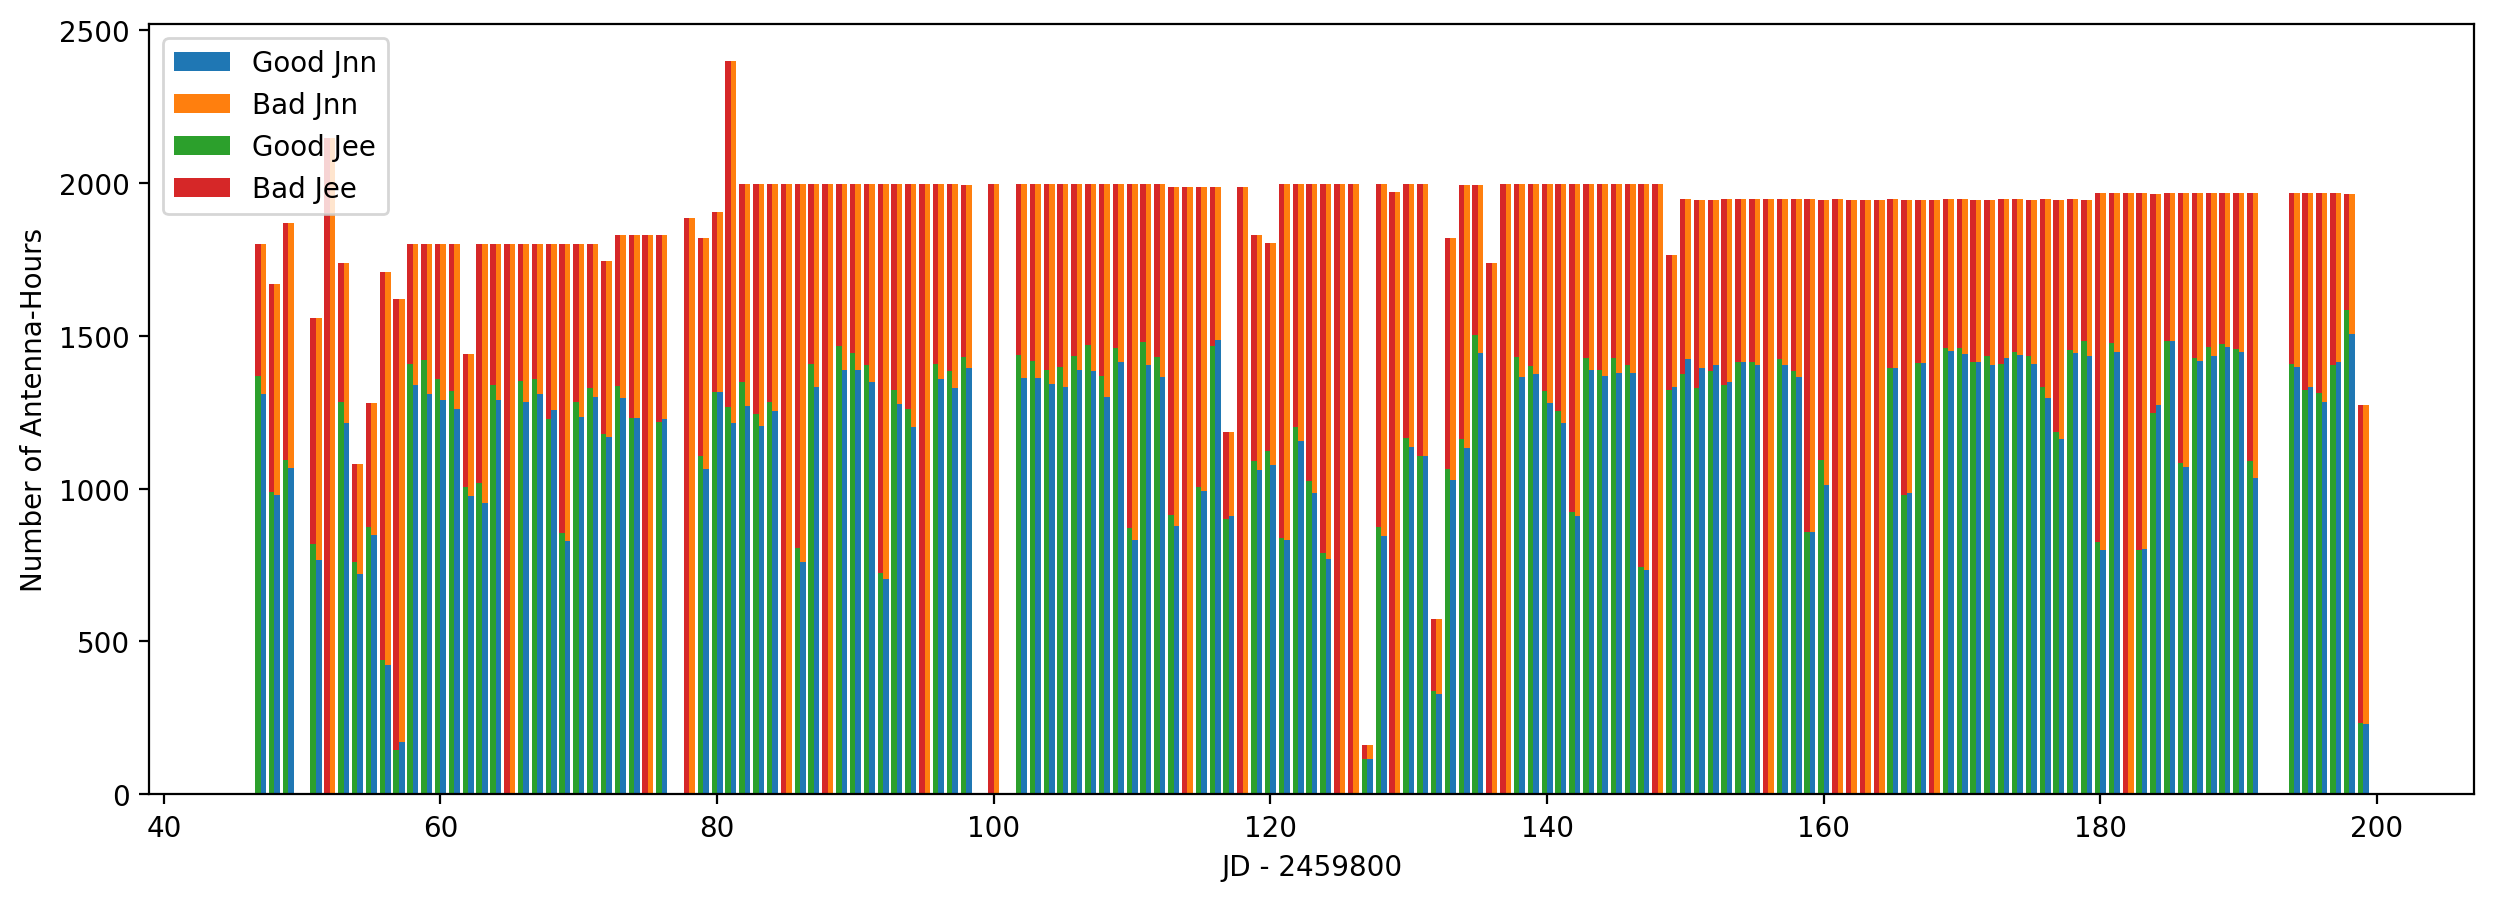

In [43]:
plt.figure(figsize=(15, 5))
for i, pol in enumerate(ngood_ants):
    if i==1:
        width=-0.4
    else:
        width=0.4
    plt.bar(all_days-2459800, [ngood_ant_hours[pol].get(d, 0) for d in all_days], align='edge', width=width, label=f'Good {pol}')
    plt.bar(all_days-2459800, [ntot_ant_hours[pol].get(d, 0) -  ngood_ant_hours[pol].get(d, 0) for d in all_days], bottom=[ngood_ant_hours[pol].get(d, 0) for d in all_days], align='edge', width=width, label=f'Bad {pol}')
plt.xlabel("JD - 2459800")
plt.ylabel("Number of Antenna-Hours")
plt.legend()

In [44]:
print("Average (total) antenna-hours per observed night (ee): ", np.mean(list(ngood_ant_hours["Jee"].values())), np.sum(list(ngood_ant_hours["Jee"].values())))
print("Average (total) antenna-hours per observed night (nn): ", np.mean(list(ngood_ant_hours["Jnn"].values())), np.sum(list(ngood_ant_hours["Jnn"].values())))

Average (total) antenna-hours per observed night (ee):  1026.4966541041374 150895.00815330818
Average (total) antenna-hours per observed night (nn):  1002.126775977943 147312.63606875762


## Antenna-Time-Frequency Flags

In [46]:
ngood_ant_hour_chans = {'Jnn': {}, 'Jee': {}}
ntot_ant_hour_chans = {'Jnn': {}, 'Jee': {}}

for pol in ['Jnn', "Jee"]:
    for jd, d in data.items():
        ntot_ant_hour_chans[pol][jd] = ntot_ant_hours[pol][jd] * 1500
        ngood_ant_hour_chans[pol][jd] = ngood_ant_hours[pol][jd] * 1500*((d['freq_range'][1] - d['freq_range'][0]) - sum((x[1]- x[0]) for x in d['freq_flags']))/(d['freq_range'][1] - d['freq_range'][0])

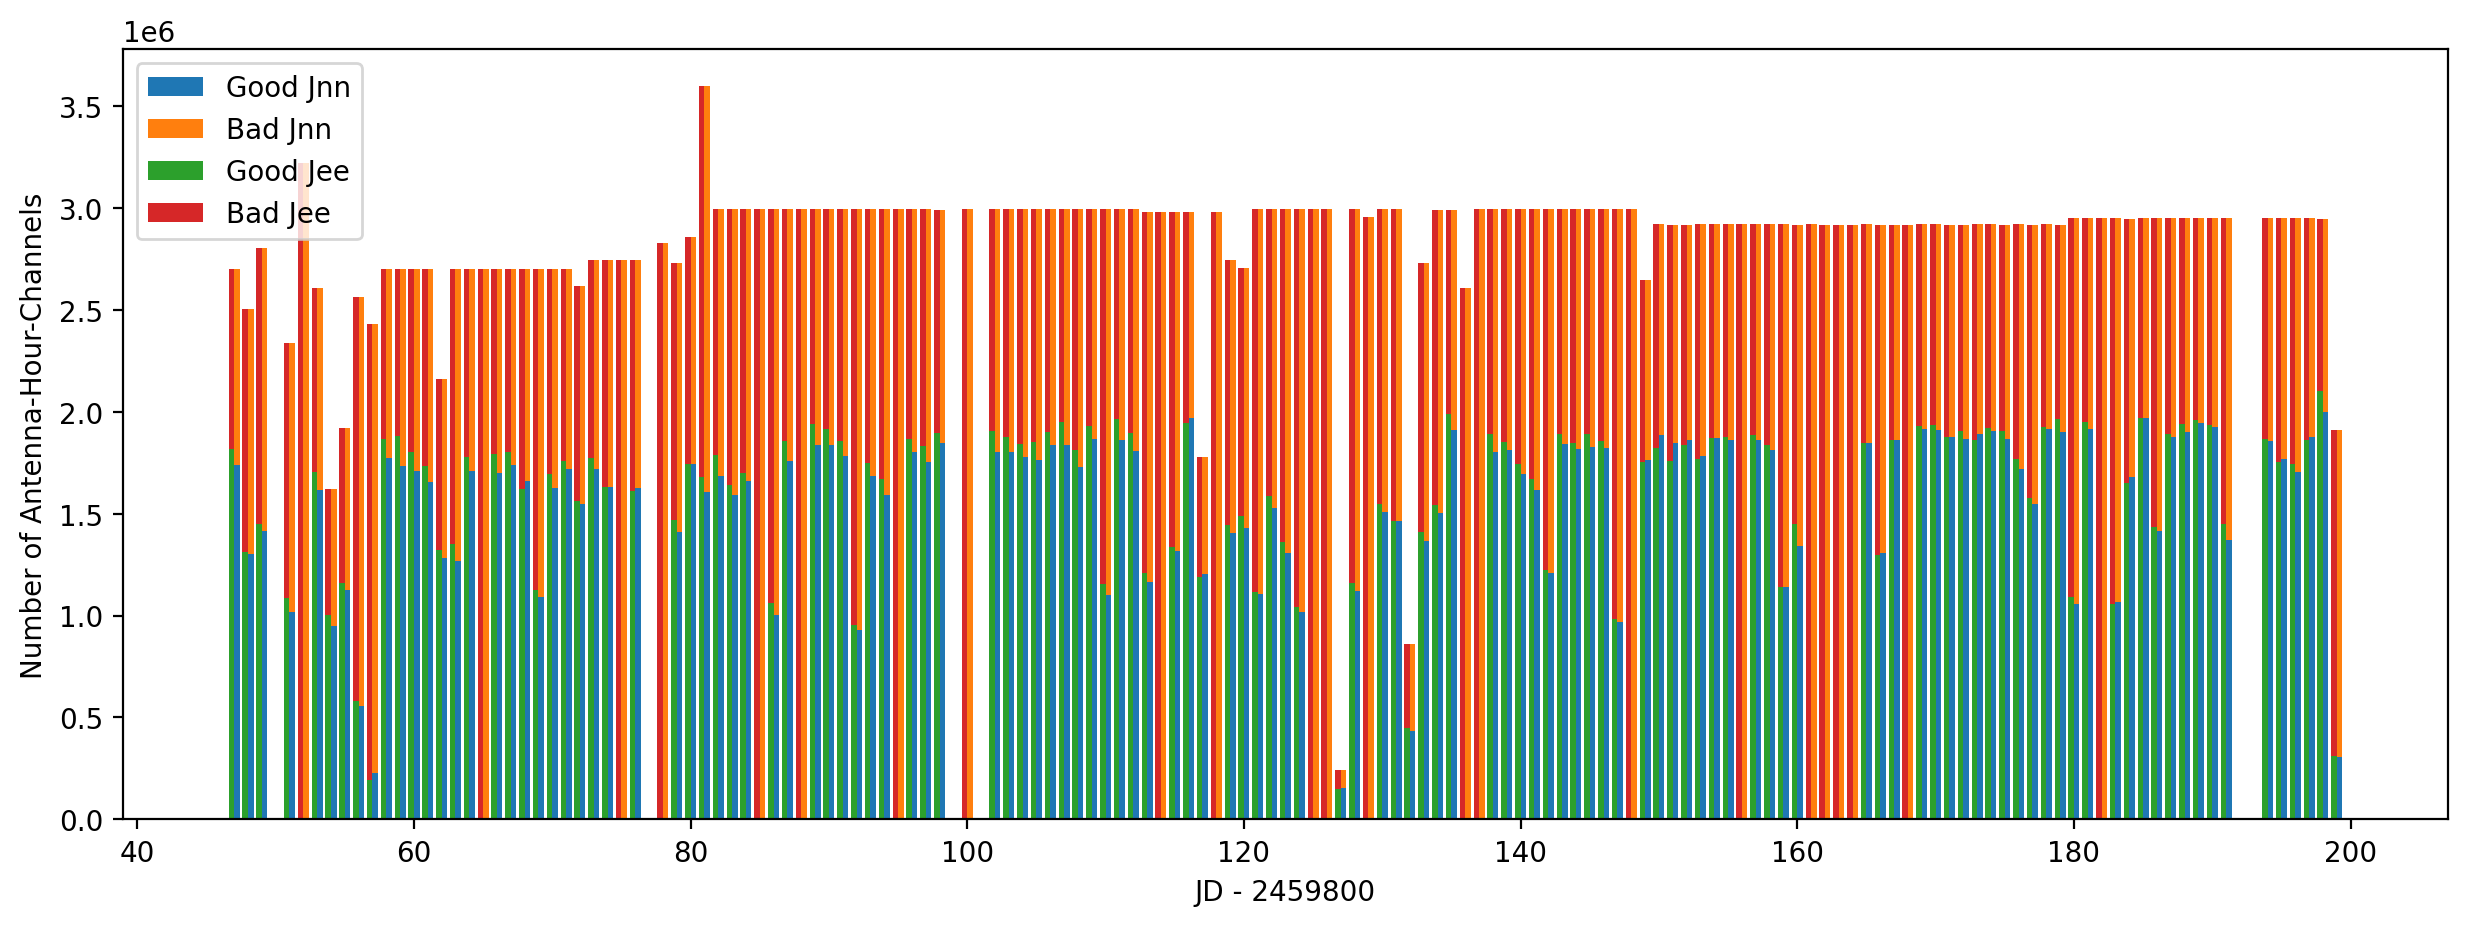

In [47]:
plt.figure(figsize=(15, 5))
for i, pol in enumerate(ngood_ants):
    if i==1:
        width=-0.4
    else:
        width=0.4
    plt.bar(all_days-2459800, [ngood_ant_hour_chans[pol].get(d, 0) for d in all_days], align='edge', width=width, label=f"Good {pol}")
    plt.bar(all_days-2459800, [ntot_ant_hour_chans[pol].get(d, 0) -  ngood_ant_hour_chans[pol].get(d, 0) for d in all_days], bottom=[ngood_ant_hour_chans[pol].get(d, 0) for d in all_days], align='edge', width=width, label=f"Bad {pol}")
plt.xlabel("JD - 2459800")
plt.ylabel("Number of Antenna-Hour-Channels")
plt.legend()

In [48]:
print(f"Fraction of total possible observed time unflagged (ee): ", np.sum(list(ngood_ant_hour_chans['Jee'].values())) / np.sum(list(ntot_ant_hour_chans['Jee'].values())))
print(f"Fraction of total possible observed time unflagged (nn): ", np.sum(list(ngood_ant_hour_chans['Jnn'].values())) / np.sum(list(ntot_ant_hour_chans['Jnn'].values())))

Fraction of total possible observed time unflagged (ee):  0.4793015309443664
Fraction of total possible observed time unflagged (nn):  0.46792413962151647


## Frequency Flags

In [49]:
fmin, fmax = next(iter(data.values()))['freq_range']
freqs = np.linspace(fmin, fmax, 1500)

freq_flag_array = np.zeros((len(all_days), len(freqs)), dtype=bool)

for i, day in enumerate(all_days):
    if day not in data:
        freq_flag_array[i] = True
    else:
        for flgs in data[day]['freq_flags']:
            freq_flag_array[i][(freqs >= flgs[0]) & (freqs < flgs[1])] = True

Text(0.5, 1.0, 'Frequency-Flagging Pattern Over Days')

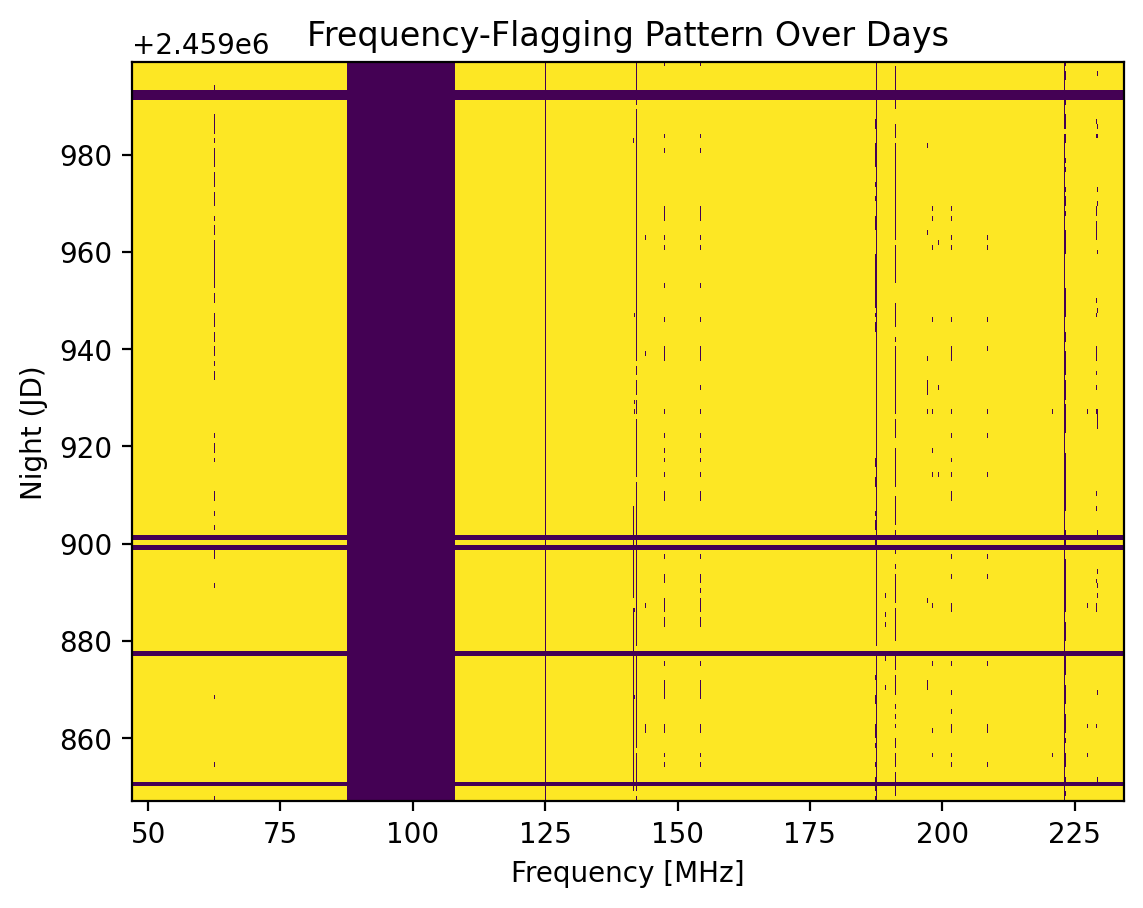

In [51]:
plt.imshow(~freq_flag_array, aspect='auto', interpolation='none', extent=(freqs.min()/1e6, freqs.max()/1e6, min(all_days), max(all_days)), origin='lower')
plt.xlabel("Frequency [MHz]")
plt.ylabel("Night (JD)")
plt.title("Frequency-Flagging Pattern Over Days")